## Imports

In [78]:
from itertools import chain, zip_longest
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

In [79]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

## Class Conditional Probabilitie
Computes the PDF (Probability Density) and integrates over an interval $x_i + \Delta_x$ to approximate the conditonal probability $P(x_i | w_j)$

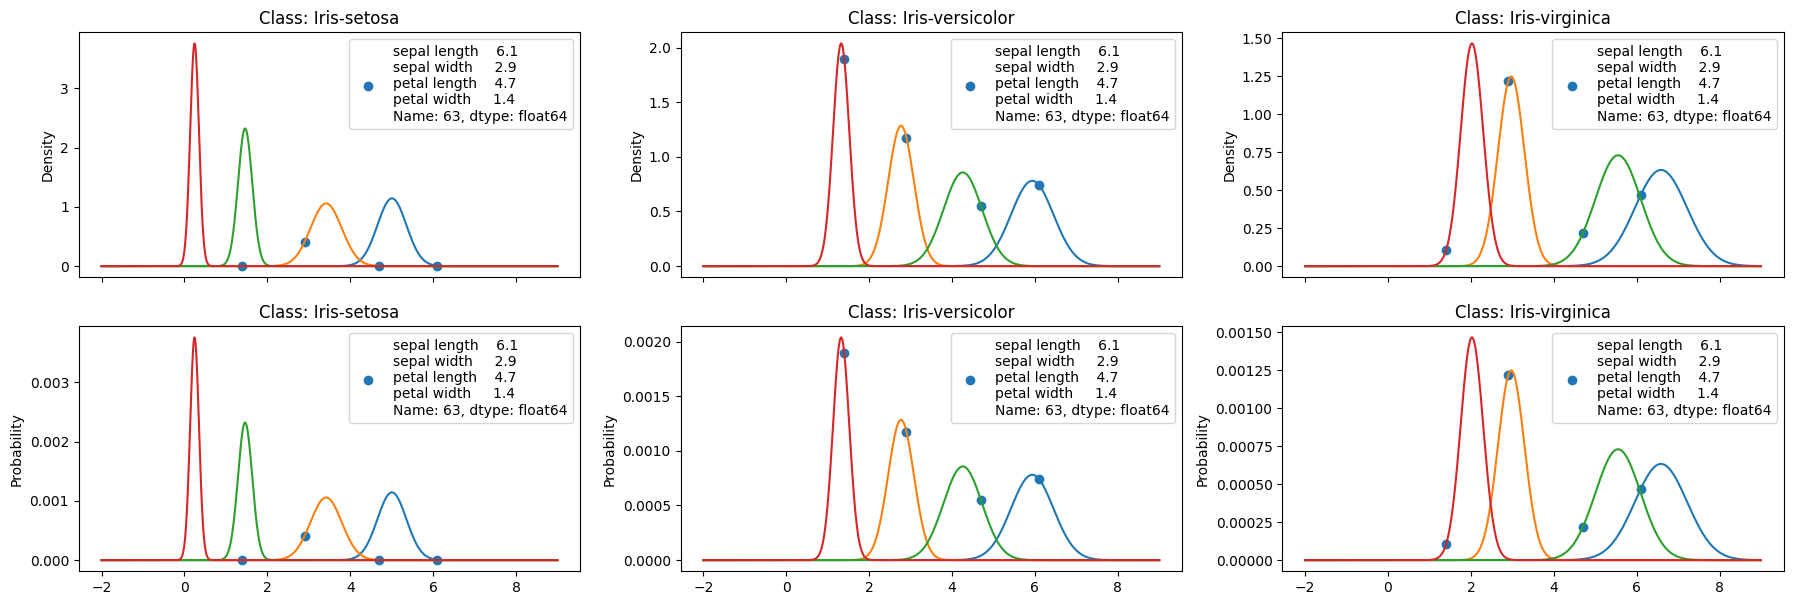

In [80]:
from code.src.utils import visualize_prob_distribution
visualize_prob_distribution(x=X, y=y)

## Naive Bayes Classifier

In [81]:
from code.src.bdt import NaiveBayes

In [82]:
nb = NaiveBayes()
pred = nb.fit(x=X, y=y)
res = pd.concat([X, y, pd.DataFrame(pred), pd.DataFrame([int(t[0] == p) for t, p in zip(y.values, pred)])], axis=1)
res.columns = [*list(res.columns[:-3]), 'actual', 'pred', 'accurate']
print(f'accuracy: {round(res.accurate.mean(), 2)}')

accuracy: 0.95


In [83]:
from code.src.utils import visualize_decision_boundary
from code.src.utils import visualize_confusion_matrix
from code.src.utils import compute_metric_table

## Descision Boundary

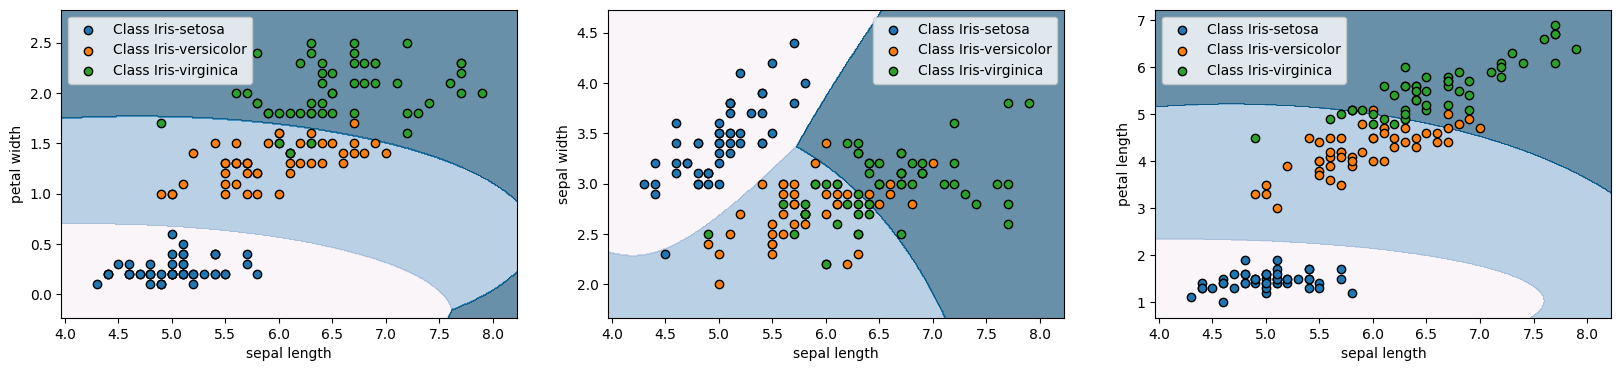

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for i, ax in enumerate(axes):
    i = 3 if i == 0 else i
    visualize_decision_boundary(x=X.iloc[:, [0, i]], y=y, predictor=lambda : NaiveBayes(integrate=False), cmap=plt.cm.PuBu, ax=ax)

## Confusion matrix

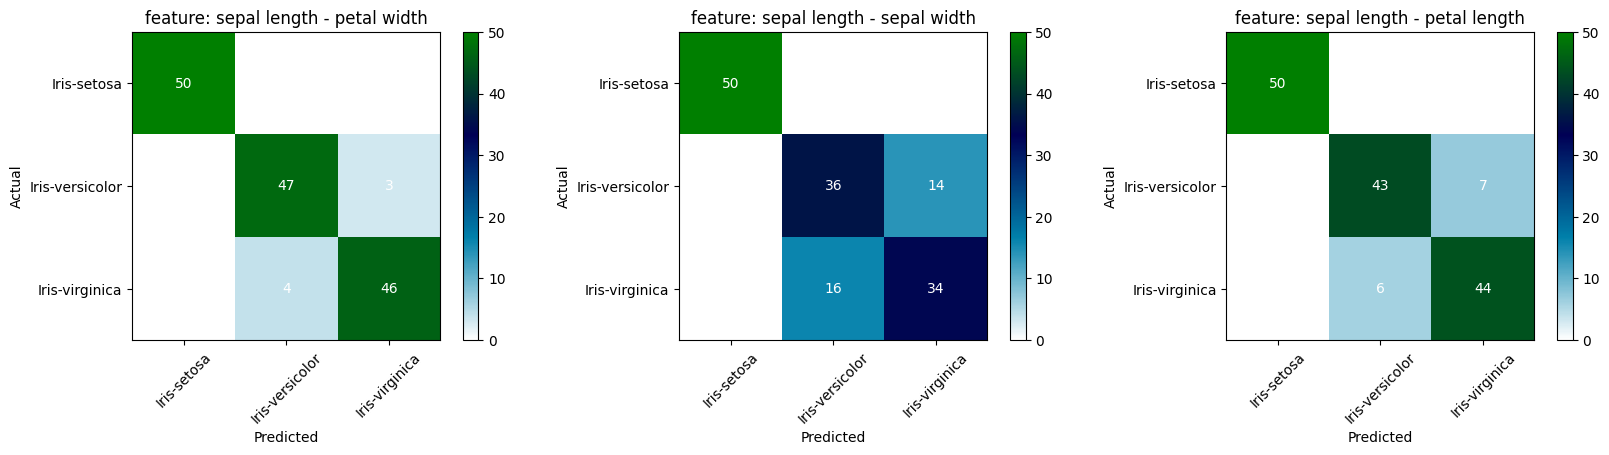

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
origin = 0
cmap = plt.cm.ocean_r
for i, ax in enumerate(axes):
    i = 3 if i == origin else i
    ft = X.iloc[:, [origin, i]]
    title = f'feature: {ft.iloc[:, 0].name} - {ft.iloc[:, 1].name}'
    predictions = NaiveBayes(integrate=False).fit(ft, y=y)
    visualize_confusion_matrix(pred=predictions, y=y, ax=ax, title=title, cmap=cmap)

## Metrics

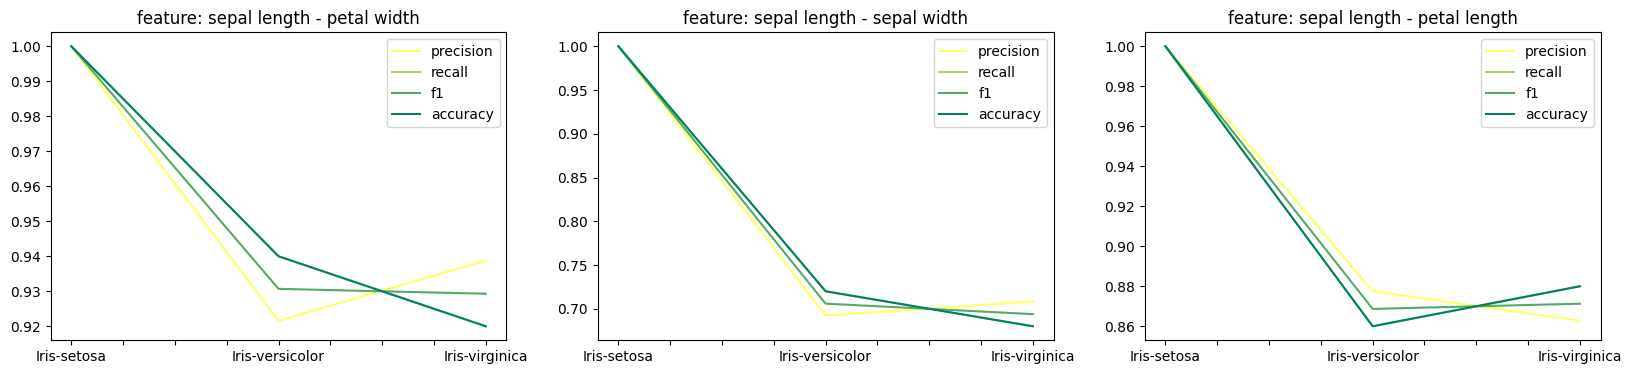

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
origin = 0
cmap = plt.cm.summer_r
for i, ax in enumerate(axes):
    i = 3 if i == origin else i
    ft = X.iloc[:, [origin, i]]
    title = f'feature: {ft.iloc[:, 0].name} - {ft.iloc[:, 1].name}'
    predictions = NaiveBayes(integrate=False).fit(ft, y=y)
    compute_metric_table(y_true=y, y_pred=predictions).plot(ax=ax, title=title, cmap=cmap)